# Lenstronomy Sandbox
5 November 2019

Arthur Tsang

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import lenstronomy

In [2]:
# For the first part: one interloper
from lenstronomy.LensModel.lens_model import LensModel
import lenstronomy.Plots.output_plots as lens_plot
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.Data.psf import PSF
from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.image_util as image_util

In [3]:
# For the second part: reconstructing convergence
#from lenstronomy.Data.imaging_data import ImageData
#from lenstronomy.ImSim.image_linear_solve import ImageLinearFit
from lenstronomy.Workflow.fitting_sequence import FittingSequence

# Intro: One interloper
One main lens, and one interloper: let's visualize this!

## Lens model

In [4]:
z_source = 1.0

lens_model_list = ['TNFW', 'TNFW']
lens_redshift_list = [0.5, 0.6]
kwargs_main = {'Rs':50, 'alpha_Rs':5, 'r_trunc':50, 'center_x':0, 'center_y':0}
kwargs_interloper = {'Rs':5, 'alpha_Rs':0.2, 'r_trunc':5, 'center_x':.5, 'center_y':.1} # instead of 0.5
kwargs_lens = [kwargs_main, kwargs_interloper]

lensModel = LensModel(lens_model_list=lens_model_list,
                      z_source=z_source,
                      lens_redshift_list=lens_redshift_list,
                      multi_plane=True)

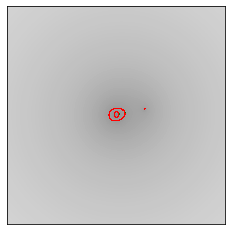

In [5]:
ax = plt.gca()
lens_plot.lens_model_plot(ax, lensModel=lensModel, kwargs_lens=kwargs_lens, with_caustics=True)
plt.show()

## Light Source

In [6]:
source_light_model_list = ['SERSIC']
kwargs_light_source = [{'amp':50000, 'R_sersic':0.02, 'n_sersic':1.5,
                        'center_x':0, 'center_y':0}]


light_model_source = LightModel(light_model_list=source_light_model_list)

In [7]:
# evaluate surface brightness at a specific position #
#flux = light_model_source.surface_brightness(x=.3, y=.3, kwargs_list=kwargs_light_source)

## Pixels and PSF

In [8]:
deltaPix = 0.05

ra_at_xy_0, dec_at_xy_0 = -2.5, -2.5 # coordinate in angles (RA/DEC) at the position of the pixel edge (0,0)
transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix # ...
    # linear translation matrix of a shift in pixel in a shift in coordinates

kwargs_pixel = {'nx': 100, 'ny': 100,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle}

pixel_grid = PixelGrid(**kwargs_pixel)

In [9]:
kwargs_psf = {'psf_type': 'GAUSSIAN',  # type of PSF model (supports 'GAUSSIAN' and 'PIXEL')
              'fwhm': 0.1,  # full width at half maximum of the Gaussian PSF (in angular units)
              'pixel_size': deltaPix  # angular scale of a pixel (required for a Gaussian PSF
                                      #   to translate the FWHM into a pixel scale)
             }
psf = PSF(**kwargs_psf)

## Image model

In [10]:
kwargs_numerics = {'supersampling_factor': 1, # each pixel gets super-sampled (in each axis direction) 
                  'supersampling_convolution': False}

imageModel = ImageModel(data_class=pixel_grid, psf_class=psf,
                       lens_model_class=lensModel,
                       source_model_class=light_model_source,
                       kwargs_numerics=kwargs_numerics)

In [11]:
image = imageModel.image(kwargs_lens=kwargs_lens, kwargs_source=kwargs_light_source)

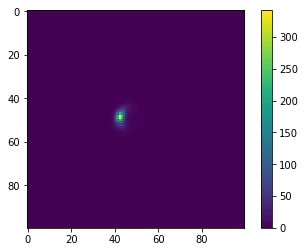

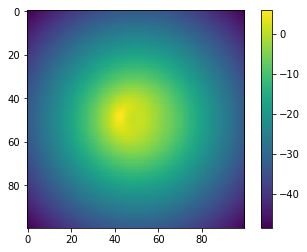

In [12]:
plt.imshow(image); plt.colorbar(); plt.show()
plt.imshow(np.log(image)); plt.colorbar(); plt.show()

## Noisy image

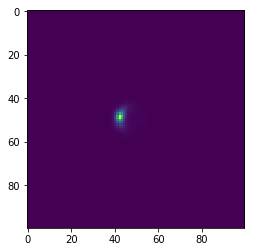

/home/arthur/Documents/cosmo/interlopers/venv/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


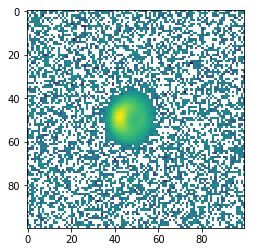

In [13]:
exp_time = 100  # exposure time to quantify the Poisson noise level (what units?)
background_rms = 0.1  # background rms value
poisson = image_util.add_poisson(image, exp_time=exp_time)
bkg = image_util.add_background(image, sigma_bkd=background_rms)
image_noisy = image + bkg + poisson
plt.imshow(image_noisy); plt.show()
plt.imshow(np.log(image_noisy)); plt.show()

There's a lot going on there. I should (at some point) abstract away all the variables that I'm not interested in changing...

# Reconstructing an effective convergence
We want to see how well we can reconstruct a convergence for this. I guess the easiest thing to try is to fit this as the macro model + substructure at the same plane.

__Note__ : I _think_ this whole thing automatically does the fitting to a single plane by default, since I don't think I wrote in any redshifts anywhere, but I'm not completely sure.

## Single plane reconstruction

In [14]:
# what's the point of `kwargs_data_joint` ? It goes into `FittingSequence`
kwargs_data = {'image_data': image_noisy,
               'background_rms': background_rms,
               'exposure_time': exp_time,
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,
               'transform_pix2angle': transform_pix2angle}
single_band = [[kwargs_data, kwargs_psf, kwargs_numerics]]
kwargs_data_joint = {'multi_band_list': single_band, 'multi_band_type': 'multi-linear'} 

### Single-plane model

In [15]:
lens_model_list

['TNFW', 'TNFW']

In [16]:
kwargs_lens

[{'Rs': 50, 'alpha_Rs': 5, 'center_x': 0, 'center_y': 0, 'r_trunc': 50},
 {'Rs': 5, 'alpha_Rs': 0.2, 'center_x': 0.5, 'center_y': 0.1, 'r_trunc': 5}]

Actually, we need to have five versions of this: init, sigma, fixed, lower, upper

In [59]:
kwargs_lens_init = [{'Rs':50, 'alpha_Rs':5, 'r_trunc':50, 'center_x': 0, 'center_y': 0},
                    {'Rs':5, 'alpha_Rs':.2, 'r_trunc':5, 'center_x': .3, 'center_y': .3}]
kwargs_lens_sigma = [{'Rs':10, 'alpha_Rs':1, 'r_trunc':10, 'center_x':.5, 'center_y':.5},
                     {'Rs':1, 'alpha_Rs':.04, 'r_trunc':1, 'center_x':.5, 'center_y':.5}]
kwargs_lens_fixed = [{},{}] #[{'Rs':, 'alpha_Rs':, 'r_trunc':},{'Rs':, 'alpha_Rs':, 'r_trunc':}]
kwargs_lens_lower = [{'Rs':1, 'alpha_Rs':.01, 'r_trunc':1, 'center_x':-2, 'center_y':-2},
                     {'Rs':.1, 'alpha_Rs':.001, 'r_trunc':.1, 'center_x':-2, 'center_y':-2}]
kwargs_lens_upper = [{'Rs':500, 'alpha_Rs':50, 'r_trunc':500, 'center_x':2, 'center_y':2},
                     {'Rs':50, 'alpha_Rs':20, 'r_trunc':50, 'center_x':2, 'center_y':2}]

kwargs_lens_guess = [kwargs_lens_init,
    kwargs_lens_sigma,
    kwargs_lens_fixed,
    kwargs_lens_lower,
    kwargs_lens_upper]

In [60]:
kwargs_light_source

[{'amp': 50000,
  'R_sersic': 0.02,
  'n_sersic': 1.5,
  'center_x': 0,
  'center_y': 0}]

In [61]:
[{'amp': 50000, 'R_sersic': 0.02, 'n_sersic': 1.5, 'center_x': 0, 'center_y': 0}]

[{'amp': 50000,
  'R_sersic': 0.02,
  'n_sersic': 1.5,
  'center_x': 0,
  'center_y': 0}]

In [62]:
kwargs_light_source_init = [{'amp': 50000, 'R_sersic': 0.02, 'n_sersic': 1.5, 'center_x': 0, 'center_y': 0}]
kwargs_light_source_sigma = [{'amp': 5000, 'R_sersic': 0.002, 'n_sersic': .15, 'center_x': .1, 'center_y': .1}]
kwargs_light_source_fixed = [{}]#[{'amp': 50000, 'R_sersic': 0.02, 'n_sersic': 1.5, 'center_x': 0, 'center_y': 0}]
kwargs_light_source_lower = [{'amp': 1000, 'R_sersic': 0.002, 'n_sersic': .3, 'center_x': -2, 'center_y': -2}]
kwargs_light_source_upper = [{'amp': 100000, 'R_sersic': 0.2, 'n_sersic': 10, 'center_x': 2, 'center_y': 2}]

kwargs_light_source_guess = [kwargs_light_source_init,
    kwargs_light_source_sigma,
    kwargs_light_source_fixed,
    kwargs_light_source_lower,
    kwargs_light_source_upper]

In [63]:
kwargs_model = {'lens_model_list':lens_model_list, 'source_light_model_list':source_light_model_list}
    # would also put lens_light_model, if applicable
    
# Wait, what is kwargs_params? I guess it's an initial guess

kwargs_params = {'lens_model': kwargs_lens_guess,
                 'source_model': kwargs_light_source_guess}
    # would also put in kwargs_lens_light and kwargs_ps if applicable
    
kwargs_constraints = {} # I don't know what I should put here
kwargs_likelihood = {'source_marg':False} # what does this mean? Is it correct?

- Where do we put in the lens redshifts?

In [64]:
kwargs_data_joint

{'multi_band_list': [[{'image_data': array([[-0.11526994,  0.06932591, -0.03852757, ...,  0.07025881,
            -0.09137304,  0.07857252],
           [-0.08788752,  0.04599518, -0.17674387, ...,  0.13408155,
             0.05056166,  0.07937932],
           [-0.064099  , -0.01475035,  0.04732016, ...,  0.11495019,
             0.14442526, -0.07772047],
           ...,
           [-0.06378519,  0.25440849,  0.07415876, ...,  0.01373481,
             0.04239524,  0.10159167],
           [ 0.05587715, -0.03416158, -0.08840426, ...,  0.06555279,
             0.08547481, -0.07668287],
           [ 0.1504122 , -0.05901527,  0.08092644, ..., -0.07417926,
            -0.19202299, -0.00325333]]),
    'background_rms': 0.1,
    'exposure_time': 100,
    'ra_at_xy_0': -2.5,
    'dec_at_xy_0': -2.5,
    'transform_pix2angle': array([[0.05, 0.  ],
           [0.  , 0.05]])},
   {'psf_type': 'GAUSSIAN', 'fwhm': 0.1, 'pixel_size': 0.05},
   {'supersampling_factor': 1, 'supersampling_convolution': F

In [65]:
kwargs_model

{'lens_model_list': ['TNFW', 'TNFW'], 'source_light_model_list': ['SERSIC']}

In [66]:
kwargs_constraints

{}

In [67]:
kwargs_likelihood

{'source_marg': False}

In [68]:
kwargs_params

{'lens_model': [[{'Rs': 50,
    'alpha_Rs': 5,
    'r_trunc': 50,
    'center_x': 0,
    'center_y': 0},
   {'Rs': 5, 'alpha_Rs': 0.2, 'r_trunc': 5, 'center_x': 0.3, 'center_y': 0.3}],
  [{'Rs': 10, 'alpha_Rs': 1, 'r_trunc': 10, 'center_x': 0.5, 'center_y': 0.5},
   {'Rs': 1,
    'alpha_Rs': 0.04,
    'r_trunc': 1,
    'center_x': 0.5,
    'center_y': 0.5}],
  [{}, {}],
  [{'Rs': 1, 'alpha_Rs': 0.01, 'r_trunc': 1, 'center_x': -2, 'center_y': -2},
   {'Rs': 0.1,
    'alpha_Rs': 0.001,
    'r_trunc': 0.1,
    'center_x': -2,
    'center_y': -2}],
  [{'Rs': 500, 'alpha_Rs': 50, 'r_trunc': 500, 'center_x': 2, 'center_y': 2},
   {'Rs': 50, 'alpha_Rs': 20, 'r_trunc': 50, 'center_x': 2, 'center_y': 2}]],
 'source_model': [[{'amp': 50000,
    'R_sersic': 0.02,
    'n_sersic': 1.5,
    'center_x': 0,
    'center_y': 0}],
  [{'amp': 5000,
    'R_sersic': 0.002,
    'n_sersic': 0.15,
    'center_x': 0.1,
    'center_y': 0.1}],
  [{}],
  [{'amp': 1000,
    'R_sersic': 0.002,
    'n_sersic': 0.3,
 

In [69]:
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model,
                              kwargs_constraints, kwargs_likelihood, kwargs_params)

In [84]:
# walkerRatio: number of walkers / number of free parameters
# sigma_scale: scaling of initial parameter spread relative to width in initial settings
fitting_kwargs_list = [['MCMC', {'n_burn':10, 'n_run':300, 'walkerRatio':10, 'sigma_scale':.1}]]

In [85]:
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)

14000 14 14 shape of init_sample
re-using previous samples to initialize the next MCMC run.
Computing the MCMC...
Number of walkers =  140
Burn-in iterations:  10
Sampling iterations: 300
241.13069486618042 time taken for MCMC sampling


In [86]:
chain_list

[['EMCEE', array([[ 5.00882350e+01,  4.85687147e+00,  5.05389420e+01, ...,
           1.48082630e+00, -6.25031749e-03, -4.54559708e-03],
         [ 4.97575702e+01,  5.03940729e+00,  5.02319364e+01, ...,
           1.49234083e+00,  8.97429220e-04,  3.85057268e-03],
         [ 4.96637278e+01,  4.93592405e+00,  4.98633714e+01, ...,
           1.51368360e+00,  2.72978230e-03, -4.40271508e-03],
         ...,
         [ 5.39889406e+01,  5.16019228e+00,  5.37260332e+01, ...,
           1.48880516e+00, -1.92391205e-02, -2.70845987e-03],
         [ 5.25857311e+01,  5.09307715e+00,  5.23220836e+01, ...,
           1.50251370e+00, -1.81796569e-02, -3.24486819e-03],
         [ 5.09836349e+01,  4.96153448e+00,  5.44468802e+01, ...,
           1.47120438e+00, -1.67228545e-02, -1.45127409e-03]]), ['Rs_lens0',
   'alpha_Rs_lens0',
   'r_trunc_lens0',
   'center_x_lens0',
   'center_y_lens0',
   'Rs_lens1',
   'alpha_Rs_lens1',
   'r_trunc_lens1',
   'center_x_lens1',
   'center_y_lens1',
   'R_sersic_

0 Rs_lens0


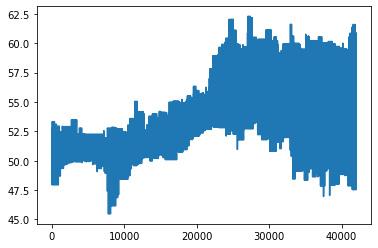

1 alpha_Rs_lens0


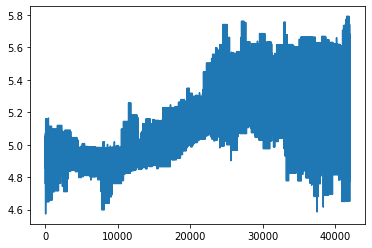

2 r_trunc_lens0


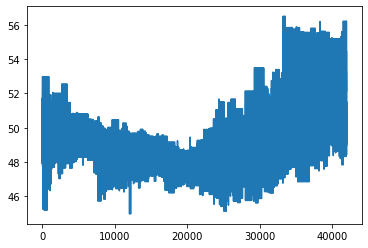

3 center_x_lens0


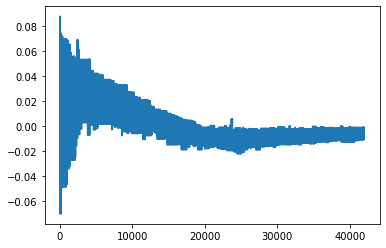

4 center_y_lens0


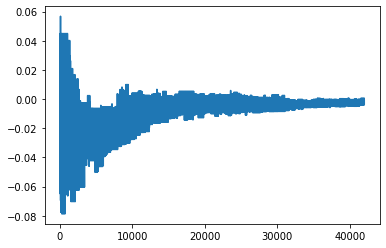

5 Rs_lens1


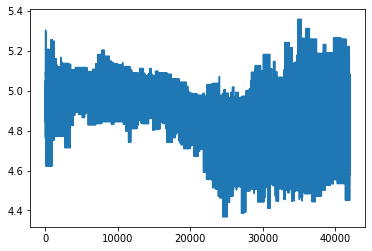

6 alpha_Rs_lens1


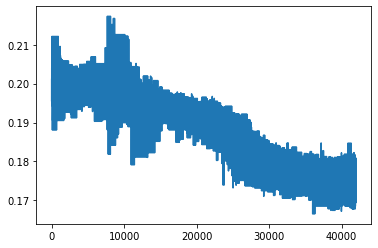

7 r_trunc_lens1


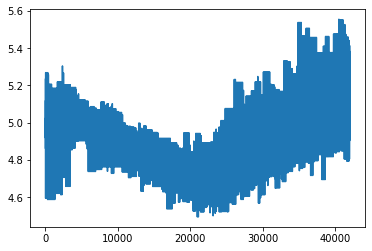

8 center_x_lens1


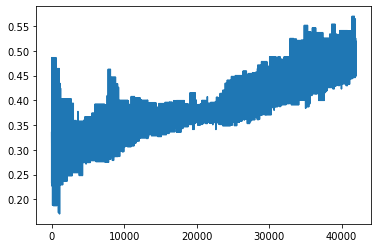

9 center_y_lens1


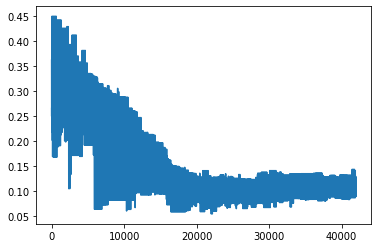

10 R_sersic_source_light0


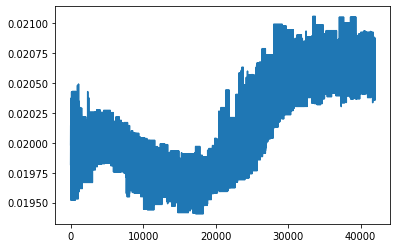

11 n_sersic_source_light0


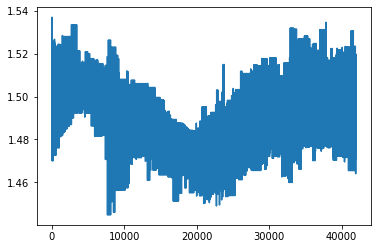

12 center_x_source_light0


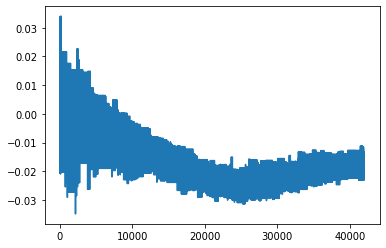

13 center_y_source_light0


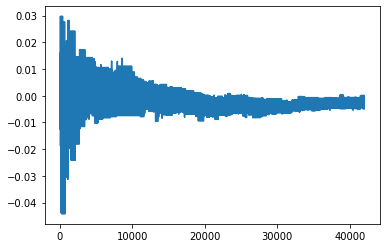

In [87]:
for i in range(14):
    print(i, chain_list[0][2][i])
    plt.plot(chain_list[0][1][:,i])
    plt.show()

## Compare fitted picture with original picture

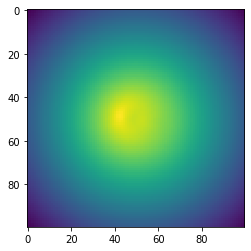

In [92]:
# Original picture!
plt.imshow(np.log(image))

In [93]:
fitdico = {}
for key, val in zip(chain_list[0][2], chain_list[0][1].T):
    fitdico[key] = np.mean(val[-100:]) # this is arbitrary, of course!
fitdico

{'Rs_lens0': 53.64573792708023,
 'alpha_Rs_lens0': 5.161393314845635,
 'r_trunc_lens0': 51.82305360007793,
 'center_x_lens0': -0.006417485267736972,
 'center_y_lens0': -0.0022215036951760262,
 'Rs_lens1': 4.868740324935224,
 'alpha_Rs_lens1': 0.17482135334935275,
 'r_trunc_lens1': 5.134342666926643,
 'center_x_lens1': 0.48366163972395815,
 'center_y_lens1': 0.11311618833509876,
 'R_sersic_source_light0': 0.020651840156499058,
 'n_sersic_source_light0': 1.4970066803988642,
 'center_x_source_light0': -0.01774757346108031,
 'center_y_source_light0': -0.002691214906716766}

In [94]:
lens_redshift_list_oneplane = [0.5, 0.5]
kwargs_main_fit = {'Rs': fitdico['Rs_lens0'],
                   'alpha_Rs':fitdico['alpha_Rs_lens0'],
                   'r_trunc':fitdico['r_trunc_lens0'],
                   'center_x':fitdico['center_x_lens0'],
                   'center_y':fitdico['center_y_lens0']}
kwargs_interloper_fit = {'Rs': fitdico['Rs_lens1'],
                   'alpha_Rs':fitdico['alpha_Rs_lens1'],
                   'r_trunc':fitdico['r_trunc_lens1'],
                   'center_x':fitdico['center_x_lens1'],
                   'center_y':fitdico['center_y_lens1']}
kwargs_lens_fit = [kwargs_main_fit, kwargs_interloper_fit]

lens_model_fit = LensModel(lens_model_list, z_source=z_source,
                          multi_plane=False) # if they complain, add in lens_redshift_list=[0.5, 0.5]

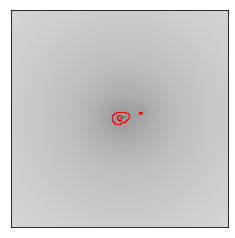

In [95]:
ax = plt.gca()
lens_plot.lens_model_plot(ax, lensModel=lens_model_fit, kwargs_lens=kwargs_lens_fit, with_caustics=True)
plt.show()

In [97]:
# not sure what's going on with a lack of `amp` in the MCMC... probably has to do with some special rule in the code
kwargs_source_fit = [{'amp':50000,
                      'R_sersic':fitdico['R_sersic_source_light0'],
                      'n_sersic':fitdico['n_sersic_source_light0'],
                      'center_x':fitdico['center_x_source_light0'],
                      'center_y':fitdico['center_y_source_light0']}]

Pixels and PSF will be identical.

Image model. (`kwargs_numerics` will also be identical)

In [96]:
image_model_fit = ImageModel(data_class=pixel_grid, psf_class=psf,
                            lens_model_class=lens_model_fit,
                            source_model_class=light_model_source,
                            kwargs_numerics=kwargs_numerics)

In [98]:
image_fit = imageModel.image(kwargs_lens=kwargs_lens_fit, kwargs_source=kwargs_source_fit)

image (multiplane):


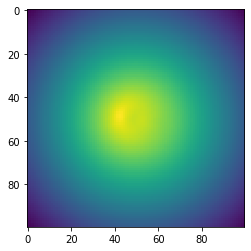

image (single plane fit)


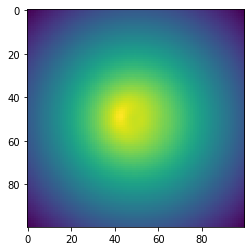

In [107]:
print('image (multiplane):')
plt.imshow(np.log(image));plt.show()
print('image (single plane fit)')
plt.imshow(np.log(image_fit));plt.show()

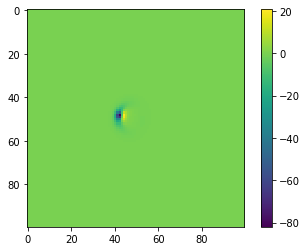

In [108]:
# the 'residual'
plt.imshow(image_fit - image);plt.colorbar()

**TODO** : compare with "naive" fit

# *Ignore below*

---

*Actually, never mind these two sections. We should be using the `FittingSequence` class instead!*

I won't delete it yet, because there's no need to.

## (old) Multiplane reconstruction
We expect we should not be able to do any better than this.

In [30]:
kwargs_data = {'image_data': image,
               'background_rms': background_rms,
               'exposure_time': exp_time,
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,
               'transform_pix2angle': transform_pix2angle} 
data_class = ImageData(**kwargs_data)

NameError: name 'ImageData' is not defined

In [ ]:
image_linear_fit = ImageLinearFit(data_class=data_class, psf_class=psf, lens_model_class=lensModel,
                        source_model_class=light_model_source,
                        #lens_light_model_class=lightModel_lens,
                        #point_source_class=pointSource, 
                        kwargs_numerics=kwargs_numerics)

# we do not require the knowledge of the linear parameters #
del kwargs_light_source[0]['amp']
# apply the linear inversion to fit for the noisy image #
image_reconstructed, _, _, _ = image_linear_fit.image_linear_solve(
    kwargs_lens=kwargs_lens,
    kwargs_source=kwargs_light_source)
    #kwargs_lens_light=kwargs_light_lens,
    #kwargs_ps=kwargs_ps

In [ ]:
plt.imshow(image_reconstructed) ; plt.colorbar() ; plt.show()
plt.imshow(np.log(image_reconstructed)) ; plt.show()

In [ ]:
plt.imshow(image_reconstructed - image); plt.colorbar(); plt.show()

## (old) Single plane reconstruction

In [ ]:
z_source = 1.0
z_lens = 0.5

lens_model_list = ['TNFW', 'TNFW']
lens_redshift_list = [z_lens, z_lens]

lensModel_flat = LensModel(lens_model_list=lens_model_list,
                      z_source=z_source,
                      lens_redshift_list=lens_redshift_list,
                      multi_plane=False) # maybe specifying the redshift list is redundant, but that's ok...

In [ ]:
image_linear_fit = ImageLinearFit(data_class=data_class, psf_class=psf, lens_model_class=lensModel_flat,
                        source_model_class=light_model_source,
                        #lens_light_model_class=lightModel_lens,
                        #point_source_class=pointSource, 
                        kwargs_numerics=kwargs_numerics)

In [ ]:
image_reconstructed, _, _, _ = image_linear_fit.image_linear_solve(
    kwargs_lens=kwargs_lens,
    kwargs_source=kwargs_light_source)

In [ ]:
plt.imshow(image_reconstructed)

In [ ]:
plt.imshow(np.log(image_reconstructed))

In [ ]:
        
        
#         lens_model_list = ['SPEP','CONVERGENCE']
#         for i in range(N):
#             lens_model_list.append('NFW')



            
#         if zl >= zd:
#             redshift_list = [zd]
#             for i in range(N):
#                 redshift_list.append(zd)
#             redshift_list.append(zl)
#         else:
#             redshift_list = [zl,zd]
#             for i in range(N):
#                 redshift_list.append(zd)